<a href="https://colab.research.google.com/github/vijayshankarrealdeal/GoogleColab/blob/main/Poem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [181]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD

try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

In [182]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

# load in the data
input_texts = []
target_texts = []
for line in open('/content/txt.txt'):
  line = line.rstrip()
  if not line:
    continue

  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)


all_lines = input_texts + target_texts

In [187]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)


# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Max sequence length: 12
Found 3056 unique tokens.


In [188]:
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


In [171]:
# !wget 'https://nlp.stanford.edu/data/glove.6B.zip'

In [172]:
# !unzip '/content/glove.6B.zip' -d '/content/glove'

In [185]:
with open('/content/glove/glove.6B.50d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [189]:
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1



embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
)

In [192]:
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(learning_rate=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)


9/9 [==============================] - 1s 122ms/step - loss: 1.8907 - accuracy: 0.3225 - val_loss: 6.7674 - val_accuracy: 0.0622
Epoch 218/2000
9/9 [==============================] - 1s 117ms/step - loss: 1.8867 - accuracy: 0.3246 - val_loss: 6.7206 - val_accuracy: 0.0625
Epoch 219/2000
9/9 [==============================] - 1s 115ms/step - loss: 1.8845 - accuracy: 0.3257 - val_loss: 6.7475 - val_accuracy: 0.0642
Epoch 220/2000
9/9 [==============================] - 1s 121ms/step - loss: 1.8818 - accuracy: 0.3257 - val_loss: 6.7948 - val_accuracy: 0.0622
Epoch 221/2000
9/9 [==============================] - 1s 117ms/step - loss: 1.8754 - accuracy: 0.3244 - val_loss: 6.7758 - val_accuracy: 0.0599
Epoch 222/2000
9/9 [==============================] - 1s 119ms/step - loss: 1.8673 - accuracy: 0.3281 - val_loss: 6.8041 - val_accuracy: 0.0619
Epoch 223/2000
9/9 [==============================] - 1s 120ms/step - loss: 1.8641 - accuracy: 0.3298 - val_loss: 6.8293 - val_accuracy: 0.0619
Epoch 2

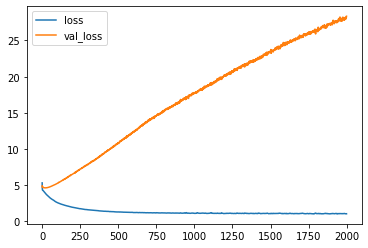

In [193]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

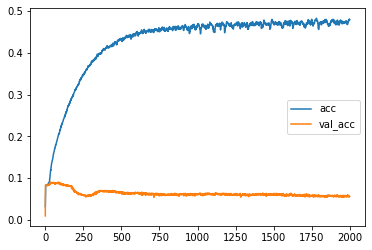

In [194]:

plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [199]:
input2 = Input(shape=(1,))
x = embedding_layer(input2)
x,h,c = lstm(x,initial_state=[initial_h,initial_c])
output2 = dense(x)
sampleing_model = Model([input2,initial_h,initial_c],[output2,h,c])

In [200]:
idx2word = {v:k for k,v in word2idx.items()}

In [205]:
def sample_line():
  np_input = np.array([[word2idx['<sos>']]])
  h = np.zeros((1,LATENT_DIM))
  c = np.zeros((1,LATENT_DIM))
  eos = word2idx['<eos>']
  output_sentence = []
  for _ in range(max_sequence_length):
    o,h,c = sampleing_model.predict([np_input,h,c])
    probs = o[0,0]
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs),p = probs)
    if idx == eos:
      break
    output_sentence.append(idx2word.get(idx,'<WTF %s>'%idx))
    np_input[0,0] = idx
  return ' '.join(output_sentence)


In [206]:
while True:
  for _ in range(4):
    print(sample_line())
  ans = input("__genrate another ? [Y/n]")
  if ans and ans[0].lower().startswith('n'):
    break

what do you think you're like all 'twas not me bewitched raining.
the door; they halted helpless on the landing,
and taken thus into the family.
so if i'd wa'n't but water within: within:
__genrate another ? [Y/n]Y
i went to sleep before i went to judged
"well—i—be—" that was all you
transfixed on mountain slopes almost anything.
he looked back in lifted storm outdoors.
__genrate another ? [Y/n]Y
and left it lying looking for especially voted mistake.
they filled their throats
will leave their tatters hung on barb and thorn.)
i have looked down there else mow lightning into tender cars hears
__genrate another ? [Y/n]n
